# Analysis of transaction lifecycle

<strong><font color="red">DRAFT: NEEDS QA REVIEW</font></strong>

*How long does it take, after a transaction is reaches the memory pool, for it to be reference by an RB?*

![Diagram of Leios pipeline stages](tx-to-block-fig1.png)

![Description of Leios pipeline stages](tx-to-block-fig2.png)

## Setup

### Packages

In [1]:
suppressMessages({
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

### Negative binomial distribution

We're only interested in the time to the first success, the random variable $\mathbf{S}$, so we have the following probability density and cumulative distribution, given a probability of $f$ for the event occuring in a time step.

$$
b(s, f) := \mathcal{P}[\mathbf{S} = s ] = \left( 1 - f \right) ^s \cdot f
$$

$$
B(s, f) := \mathcal{P}[\mathbf{S} \leq s] = \sum_{0 \leq t \leq s} \left( 1 - f \right) ^t \cdot f
$$


### Converting rate to probability

If $f$ is the rate of events per-trial (i.e., per-slot or per-stage), then $(1 - e^{-f})$ is the probability that at least on event will be observed in a given trial.

## Delays in stages

### Stage 1. `Propose`

Once a transaction reaches the memory pool, it waits for an IB that matches its shard constraint.

- IB production rate: $f_\text{IB}$
- Number of shards: $n_\text{shard}$
- IB production rate per shard: $f^*_\text{IB} = f_\text{IB} / n_\text{shard}$
- IB shard probability: $f^\prime_\text{IB} = 1 - e^{- f_\text{IB} / n_\text{shard}}$
- Number of slots from submitting a transaction to having it appear in an IB: $\mathbf{S_1}$
- Probability density: $p_1(s_1) := \mathcal{P}[\mathbf{S_1} = s_1] = b(s_1, f^\prime_\text{IB})$

In [2]:
p1 <- function(s, f) {
    p <- 1 - exp(-f)
    dnbinom(s, 1, p)
}

In [3]:
q1 <- function(s, f) {
    p <- 1 - exp(-f)
    pnbinom(s, 1, p)
}

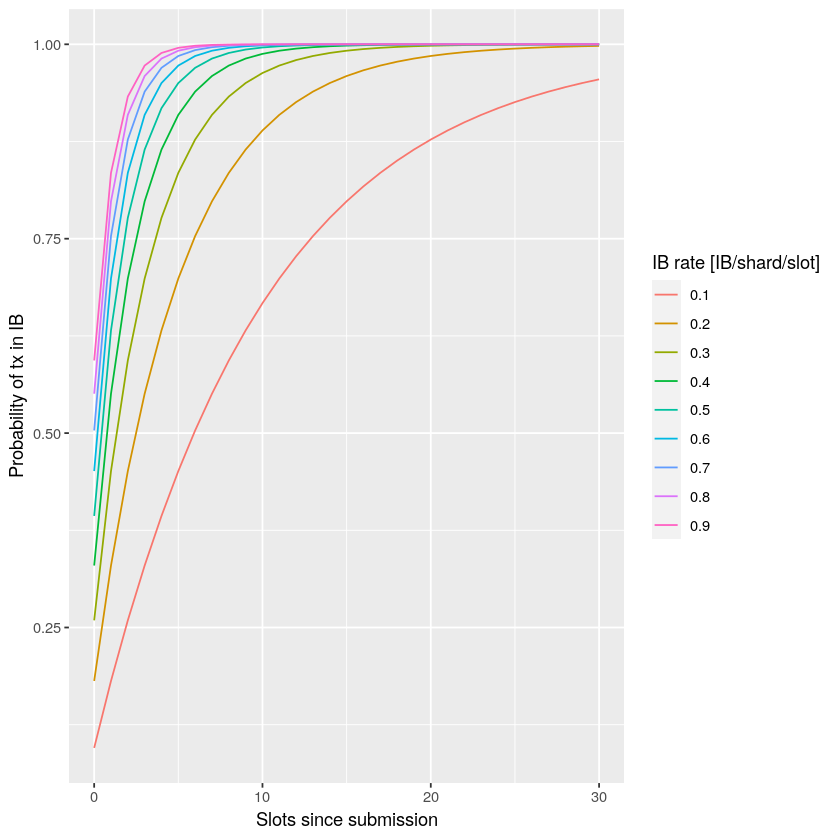

In [4]:
ggplot(
    CJ(`f'_IB`=1:9/10, `s`=0:30)[, .(
        `IB rate [IB/shard/slot]`=factor(`f'_IB`),
        `Slots since submission`=`s`,
        `Probability of tx in IB`=mapply(q1, `s`, `f'_IB`)
    )],
    aes(x=`Slots since submission`, y=`Probability of tx in IB`, color=`IB rate [IB/shard/slot]`)
) + geom_line()

### Stage 2. `Deliver1`

The transaction reaches the beginning of `Deliver1` according to a truncated negative binomial distribution.

- Stage length: $L$
- Duration of `Deliver1` stage: $\mu L$
- Number of slots from when the IB was produced to the start of Delivery1: $\mathbf{S_2}$
- Probability density: $p_2(s_2) := \mathcal{P}[\mathbf{S_2} = s_2 \, | \, \mathbf{S_2} \leq L] = \left. b(L - s_2, f^\prime_\text{IB}) \middle/ B(L - 1, f^\prime_\text{IB}) \right.$

In [5]:
p2 <- function(s, f, L) {
    p <- 1 - exp(-f)
    dnbinom(L - s, 1, p) / pnbinom(L - 1, 1, p)
}

In [6]:
q2 <- function(s, f, L) {
    p <- 1 - exp(-f)
    pnbinom(L - s, 1, p) / pnbinom(L - 1, 1, p)
}

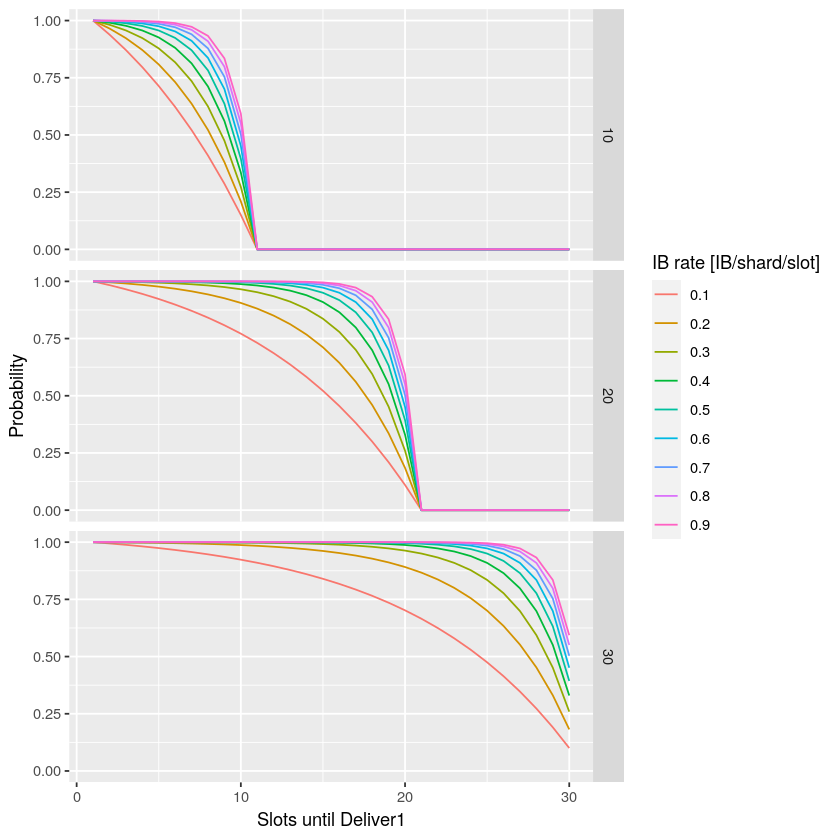

In [7]:
ggplot(
    CJ(`f'_IB`=1:9/10, `s`=1:30, `L`=c(10,20,30))[, .(
        `IB rate [IB/shard/slot]`=factor(`f'_IB`),
        `Stage length [slot]`=factor(`L`),
        `Slots until Deliver1`=`s`,
        `Probability`=mapply(q2, `s`, `f'_IB`, `L`)
    )],
    aes(x=`Slots until Deliver1`, y=`Probability`, color=`IB rate [IB/shard/slot]`)
) + geom_line() +
    facet_grid(`Stage length [slot]` ~ .)

### Stage 3. `Link`

If the IB is not included in an EB at the `Link` stage, it is orphaned forever.

- EB production rate: $f_\text{EB}$
- EB production probability: $f^\prime_\text{EB} = 1 - e^{- f_\text{EB}}$
- Whether the IB is linked to an EB: $\mathbf{S_3}$.
- Probability: $p_3(s_3) := \mathcal{P}[\mathbf{S_3} = s_3]$
    - $p_3(1) = f^\prime_\text{EB}$
    - $p_3(0) = 1 - f^\prime_\text{EB}$

In [8]:
p3 <- function(s, f) {
    p <- 1 - exp(- f)
    if (s == 0)
        1 - p
    else
        p
}

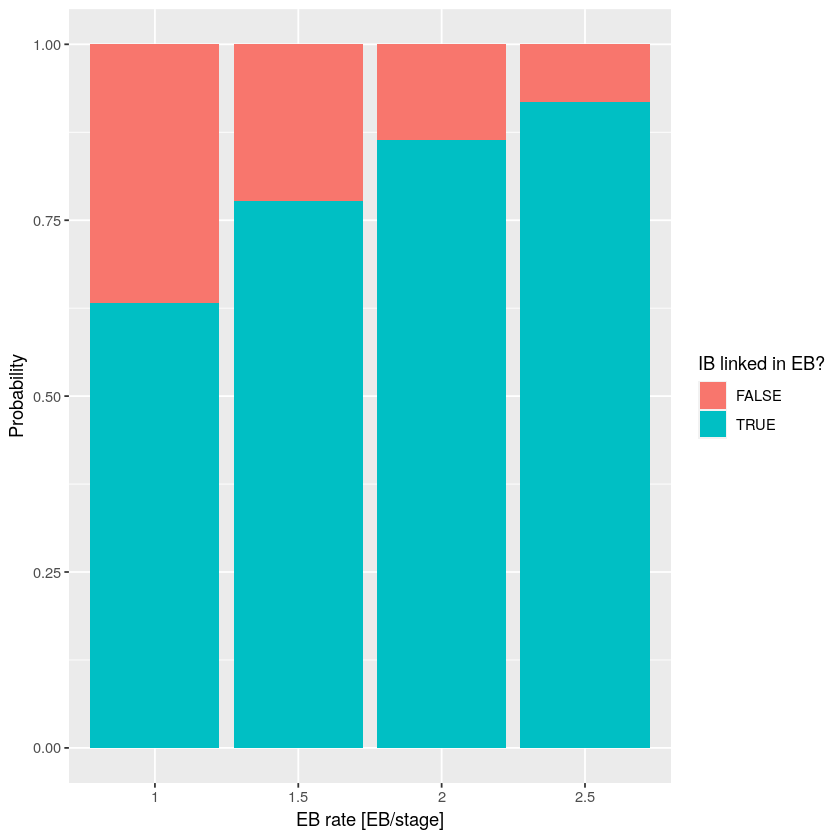

In [9]:
ggplot(
    CJ(`f_EB`=c(1.0,1.5,2.0,2.5), `s`=0:1)[, .(
        `EB rate [EB/stage]`=factor(`f_EB`),
        `IB linked in EB?`=`s`==1,
        `Probability`=mapply(p3, `s`, `f_EB`)
    )],
    aes(x=`EB rate [EB/stage]`, y=`Probability`, fill=`IB linked in EB?`)
) + geom_bar(stat="identity")

### Stage 4. `Deliver2`

The `Deliver2` stage lasts $\lambda L$ slots.

### Stage 5. `Vote1`

The `Vote1` stage lasts $L$ slots.

### Stage 6. `Endorse`

In Full Leios, the Vote1-certified EB waits for a pipeline where it is endorsed. If it is not endorsed in current pipeline, it has to skip one pipeline before it is included in a later endorsement stage.

- Number of stages before IB is endorsed: $\mathbf{S_6}$
- Probability: $p_6(s_6) := \mathcal{P}[\mathbf{S_6} = s_6]$
    - $p_6(0) = f^\prime_\text{EB}$
    - $p_6(1) = 0$
    - $p_6(s_6) = b(s_6 - 1, f^\prime_\text{EB})$, for $s > 1$

In [10]:
p6 <- function(s, f) {
    p <- 1 - exp(-f)
    if (s == 0)
        dnbinom(0, 1, p)
    else if (s == 1)
        0
    else
        dnbinom(s - 1, 1, p)
}  

In [11]:
q6 <- function(s, f) {
    p <- 1 - exp(-f)
    if (s <= 1)
        pnbinom(0, 1, p)
    else
        pnbinom(s - 1, 1, p)
}

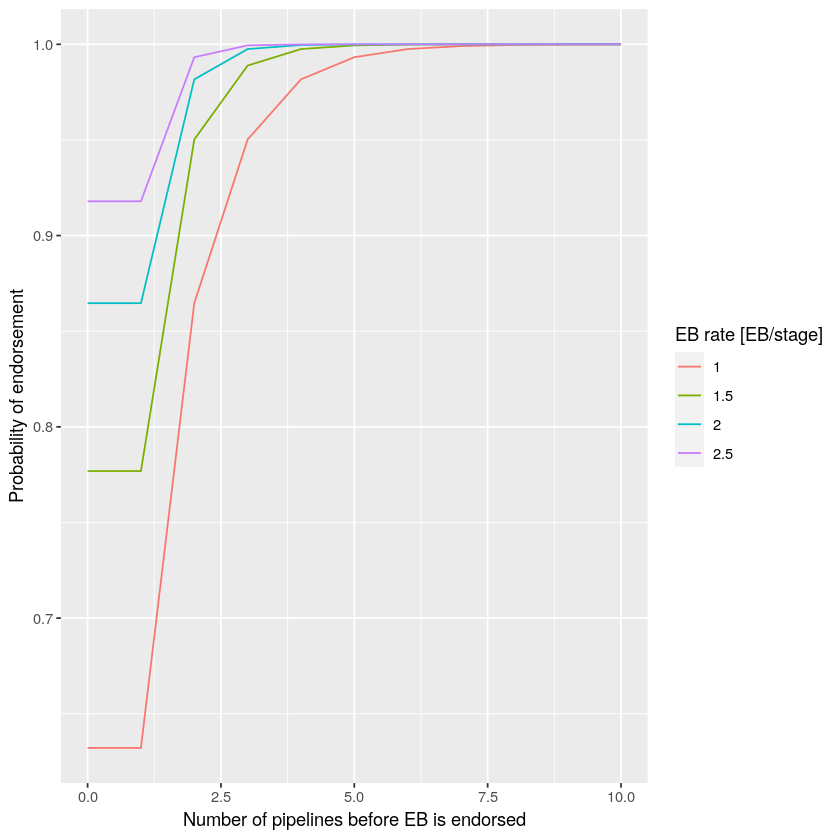

In [12]:
ggplot(
    CJ(`f'_EB`=c(1.0,1.5,2.0,2.5), `s`=0:10)[, .(
        `EB rate [EB/stage]`=factor(`f'_EB`),
        `Number of pipelines before EB is endorsed`=`s`,
        `Probability of endorsement`=mapply(q6, `s`, `f'_EB`)
    )],
    aes(x=`Number of pipelines before EB is endorsed`, y=`Probability of endorsement`, color=`EB rate [EB/stage]`)
) + geom_line()

### Stage 7. `Vote2`

The `Vote2` stage lasts $L$ slots.

### Praos

Now wait for a Praos block.

- Active slot coefficient: $f_\text{RB} = 0.05$
- Number of slots to wait for inclusion in an RB: $\mathbf{S_\text{RB}}$
- Probability density: $p_\text{RB}(s_\text{RB}) := \mathcal{P}[\mathbf{S_\text{RB}} = s_\text{RB}] = b(s_\text{RB}, 1, f_\text{RB})$

In [13]:
pRB <- function(s, f) 
    dnbinom(s, 1, f)

In [14]:
qRB <- function(s, f)
    pnbinom(s, 1, f)

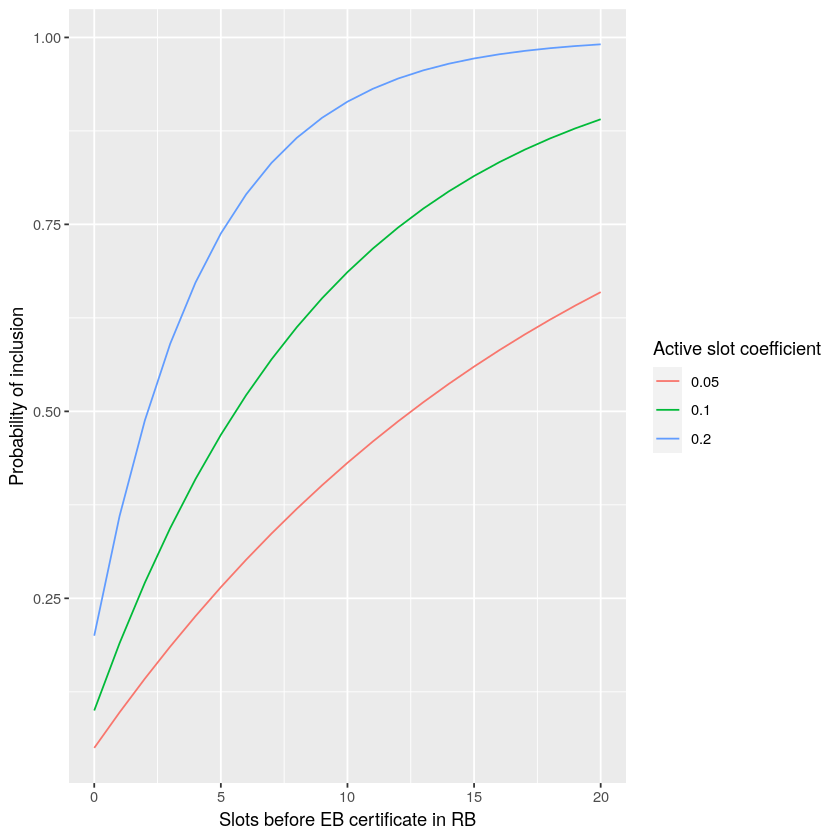

In [15]:
ggplot(
    CJ(`f_RB`=c(0.05,0.10,0.20), `s`=0:20)[, .(
        `Active slot coefficient`=factor(`f_RB`),
        `Slots before EB certificate in RB`=`s`,
        `Probability of inclusion`=mapply(qRB, `s`, `f_RB`)
    )],
    aes(x=`Slots before EB certificate in RB`, y=`Probability of inclusion`, color=`Active slot coefficient`)
) + geom_line()

## Distribution of waiting times

- Slots from transaction submission to its referencing in an RB: $\mathbf{T}$
    - $\mathbf{S_3} = 1 \implies \mathbf{T} = \mathbf{S_1} + \mathbf{S_2} + \mu L + L + \lambda L + \mathbf{S_6} (L + 1) + L + \mathbf{S_\text{RB}} = \mathbf{S_1} + \mathbf{S_2} + (\mu + \lambda + 3 + \mathbf{S_6}) L + \mathbf{S_\text{RB}}$
    - $\mathbf{S_3} = 0 \implies \mathbf{T} = \infty$
- Joint probability density: $p_T(s_1, s_2, s_3, s_6, s_\text{RB}, L, f^*_\text{IB}, f_\text{EB}, f_\text{RB}, L) = p_1(s_1, f^*_\text{IB}) \cdot p_2(s_2, f^*_\text{IB}, L) \cdot p_3(s_3, f_\text{EB}) \cdot p_6(s_6, f_\text{EB}) \cdot p_\text{RB}(s_\text{RB}, f_\text{RB})$

Because the joint probability distribution is the product of terms to variable powers, it might be feasible to evaluate the sums involved in computing the distribution of $\mathbf{T}$. For now, we'll just tabulate the result and sum numerically.

Also set $\mu = \lambda = 1$ for the example computations.

In [16]:
pttab <- function(fIB, fEB, fRB, L, mu=1, lambda=1) {
    acc <- 10
    tab1 <- data.table(`s1`=0:ceiling(acc/(1-exp(-fIB))))[, .(`DMY`=TRUE, `s1`, `p1`=mapply(p1, `s1`, fIB))]
    tab2 <- data.table(`s2`=1:L)[, .(`DMY`=TRUE, `s2`, `p2`=mapply(p2, `s2`, fIB, L))]
    tab3 <- data.table(`s3`=0:1)[, .(`DMY`=TRUE, `s3`, `p3`=mapply(p3, `s3`, fEB))]
    tab6 <- data.table(`s6`=0:ceiling(acc/(1-exp(-fEB))))[, .(`DMY`=TRUE, `s6`, `p6`=mapply(p6, `s6`, fEB))]
    tabRB <- data.table(`sRB`=0:ceiling(acc/fRB))[, .(`DMY`=TRUE, `sRB`, `pRB`=mapply(pRB, `sRB`, fRB))]
    z <- tab1[tab2, on=.(`DMY`), allow.cartesian=TRUE][, .(`DMY`=TRUE, `p`=sum(`p1`*`p2`)), .(`T`=`s1`+`s2`)]
    z <- tab6[z, on=.(`DMY`), allow.cartesian=TRUE][, .(`DMY`=TRUE, `p`=sum(`p`*`p6`)), .(`T`=`T`+(mu+lambda+3+`s6`)*L)]
    z <- tabRB[z, on=.(`DMY`), allow.cartesian=TRUE][, .(`DMY`=TRUE, `p`=sum(`p`*`pRB`)), .(`T`=`T`+`sRB`)]
    tab3[z, on=.(`DMY`), allow.cartesian=TRUE][, .(`p`=sum(`p`*`p3`)), .(`T`=`T`/`s3`)]
}

#### Check that probability is conserved.

In [17]:
pttab(0.1, 1.5, 0.05, 20)[, sum(`p`)]

[1] 0.9999442

#### Plot some examples

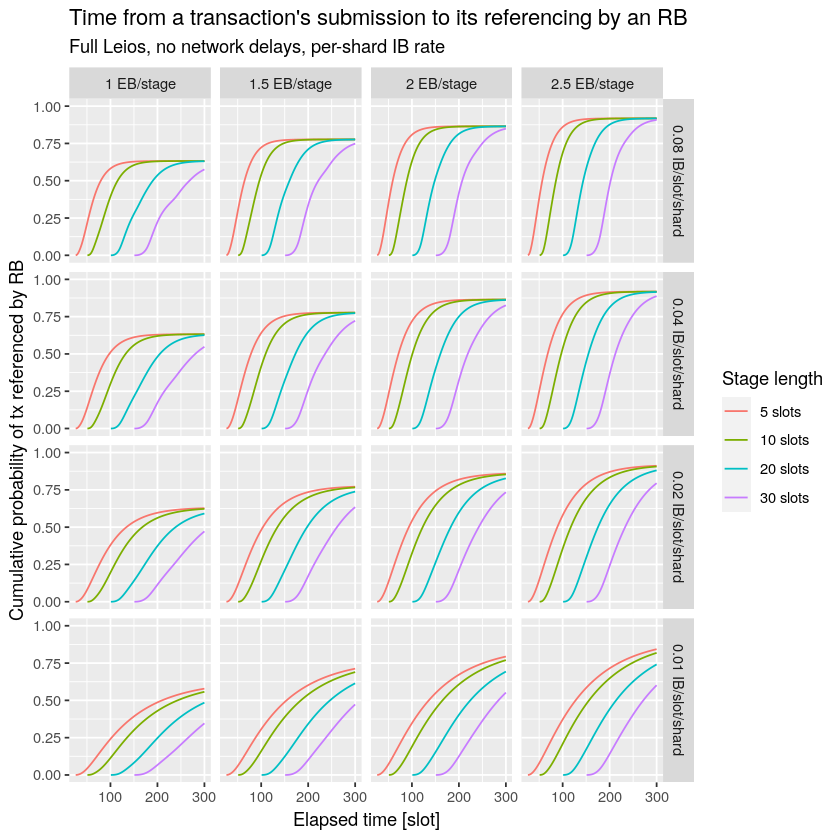

In [18]:
ggplot(
    CJ(`fIB`=c(0.01, 0.02, 0.04, 0.08), `fEB`=c(1.0, 1.5, 2.0, 2.5), `fRB`=0.05, `L`=c(5, 10, 20, 30))[,
        as.list(mapply(pttab, `fIB`, `fEB`, `fRB`, `L`)),
        by=.(`fIB`, `fEB`, `fRB`, `L`),
    ][order(`fIB`, `fEB`, `fRB`, `L`, `V1`)][
        !is.infinite(`V1`) & `V1` <= 300, 
        .(`T`=`V1`, `p`=cumsum(`V2`)), 
        .(
            `fIB`=factor(paste(`fIB`, "IB/slot/shard"), levels=c("0.08 IB/slot/shard", "0.04 IB/slot/shard", "0.02 IB/slot/shard", "0.01 IB/slot/shard")),
            `fEB`=paste(factor(`fEB`), "EB/stage"), 
            `fRB`, 
            `Stage length`=factor(paste(`L`, "slots"), levels=c("5 slots", "10 slots", "20 slots", "30 slots"))
        )
    ], 
    aes(x=`T`, y=`p`, color=`Stage length`)
) +
    geom_line() +
    ylim(0, 1) +
    facet_grid(`fIB` ~ `fEB`) +
    xlab("Elapsed time [slot]") +
    ylab("Cumulative probability of tx referenced by RB") +
    ggtitle(
        "Time from a transaction's submission to its referencing by an RB", 
        subtitle="Full Leios, no network delays, per-shard IB rate"
    )

In [19]:
ggsave("tx-to-block.png", units="in", dpi=150, width=8, height=6)

In [20]:
ggsave("tx-to-block.svg", units="in", dpi=150, width=8, height=6)

## Findings

The plot hints at the following:

1. There seems little advantage to moving to stage lengths less than 10 slots.
2. The number of shards should be kept small enough so that the IB rate per shard is high relative to the stage length.
3. Low EB rates result in many orphaned IBs.
4. Realistic parameter settings result in an approximately two-minute delay between transaction submission and its referencing by an RB.

## Next steps

- Translating this model into Delta QSD, so that network effects can be included.
- Compare this model's results to output of the Rust simulator.
- Elaborate the model in order to represent the memory-pool and ledger variants under consideration.